# Building your Deep Neural Network: Step by Step

Previously we trained a 2-layer Neural Network with a single hidden layer from scracth. In this notebook, we will build a deep neural network with as many layers as we want! Again, although a deep neural network can be easily implemented in PyTorch, this notebook is designed to help reinforce the technical knowledge you learned in the lecture. To this end, we'll implement all the functions required to build a deep neural network and we don't use PyTorch at all in this notebook.

**By the end of this notebook, we will be able to:**

- Use non-linear units like ReLU to improve your model
- Build a deeper neural network (with more than 1 hidden layer)
- Implement an easy-to-use neural network class


**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

It is important to repeat the formulation for the forward pass in defining our fully connected neural network model, and the formulation for the backward pass in the training process of the neural network.

## Summary of background theory

### <u>Forward propagation</u>
The forward propagation can be summarized in the following equation

$$
\begin{aligned}
\mathbf{Z}^{[l]} &= \mathbf{a}^{[l-1]} \mathbf{W}^{[l]T} + \mathbf{b}^{[l]} \tag{1}\\[6pt]
\mathbf{a}^{[l]} &= g(\mathbf{Z}^{[l]}) = g(\mathbf{a}^{[l-1]} \mathbf{W}^{[l]T} + \mathbf{b}^{[l]})
\end{aligned}
$$
where $\mathbf{a}^{[l]}$ is the vector of activations in the layer $l$, $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ are the weights and the bias for the connection between layer $[l-1]$ and layer $[l]$.
### <u>Backward propagation</u>

Let $\mathrm{d}\mathbf{P}$ denote the derivative of loss function $\mathcal{L}$ with respect to the variable $\mathbf{P}$, that is
$$
\mathbf{d}\mathbf{P} = \frac{\partial \mathcal{L}}{\partial \mathbf{P}}.
$$
Then, the backward propagation for layer $[l]$ can be summarized as follows
- For one training example:
$$
\begin{aligned}
\mathrm{d}z^{[l]} &= \mathrm{d}a^{[l]} \odot g^{[l]\prime} (\mathbf{z}^{[l]}) \\[6pt]
\mathrm{d}W^{[l]} &= (\mathrm{d}Z^{[l]})^{T} \mathrm{d}\mathbf{a}^{[l-1]} \phantom{\frac{1}{m}}\\[6pt]
\mathrm{d}b^{[l]} &= \mathrm{d}z^{[l]} \phantom{\frac{1}{m}} \\[6pt]
\mathrm{d}a^{[l-1]} &= \mathrm{d}z^{[l]} \mathbf{W}^{[l]}
\end{aligned}
$$
$\qquad$ where $\odot$ is the Hamadard multiplication operator. It just means element-wise multiplication.
- For a mini-batch of examples:
$$
\begin{aligned}
\mathrm{d}\mathbf{Z}^{[l]} &= \mathrm{d}\mathbf{A}^{[l]} \odot g^{[l]\prime} (\mathbf{Z}^{[l]}) \\[6pt]
\mathrm{d}\mathbf{W}^{[l]} &= \frac{1}{m}(\mathrm{d}\mathbf{Z}^{[l]})^{T} \mathrm{d}\mathbf{A}^{[l-1]} \\[6pt]
\mathrm{d}\mathbf{b}^{[l]} &= \frac{1}{m} \texttt{np.sum}\big(\mathrm{d}\mathbf{Z}^{[l]} ,\texttt{axis=0} \big)\\[6pt]
\mathrm{d}\mathbf{A}^{[l-1]} &= \mathrm{d} \mathbf{Z}^{[l]} \mathbf{W}^{[l]} \\
\end{aligned}
$$
where $m$ is the size of the batch, or the number of training examples in the batch.


In [1]:
# First, we import all the packages we'll need in this notebook

import numpy as np
import h5py
import matplotlib.pyplot as plt
from public_tests import *
from testCases import *

np.random.seed(1)

## Helper functions

To build a deep neural network, we'll be implementing several "helper functions". These helper functions will be used subsequently to build a two-layer neural network and an $L$-layer neural network. Each small helper function will have detailed documentation and the function name mostly suggest the role of the function.

### Activation functions and their backward gradient

In the backward propagation, we have to compute the derivative of the activation functions with respect to the their arguments. At the layer $l$, the activations are computed according to
$$
\begin{aligned}
\mathbf{Z}^{[l]} &= \mathbf{a}^{[l-1]} \mathbf{W}^{[l]T} + \mathbf{b}^{[l]} \tag{1}\\[6pt]
\mathbf{a}^{[l]} &= g(\mathbf{Z}^{[l]}) = g(\mathbf{a}^{[l-1]} \mathbf{W}^{[l]T} + \mathbf{b}^{[l]})
\end{aligned}
$$
where $g$ is the activation function applied at the connection between layer $l - 1$ and layer $l$. In the backward pass, in order to compute $\mathrm{d}\mathbf{Z}^{[l]}$, we need to compute the derivative $g^{\prime}(\mathbf{Z}^{[l]})$. For this reason we need to keep track of the values $\mathbf{Z}^{[l]}$ after applying linear operation $\mathbf{Z}^{[l]} = \mathbf{a}^{[l-1]} \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$. These values will be stored in the variable `cache` or we can say these values will be cached after each step of applying the activation function in the forward propagation.

As the derivative of the activation function varies depending on the actual formulation of the activation, we write two "backward" activation function for two "forward" activation function.

<font color='red'>**sigmoid function**</font>

The sigmoid function $\sigma(z)$ and its derivative are given by
$$
\sigma(z) = \frac{1}{1 + \exp(-z)} \qquad\Rightarrow\qquad \sigma^{\prime}(z) = \sigma(z) (1 - \sigma(z))
$$

<font color='red'>**Rectified Linear Unit function**</font>

The ReLU activation and its derivative are given by
$$
\mathrm{ReLU}(z) = \begin{cases}
x & x \geq 0 \\[6pt] 0 & x < 0
\end{cases}\qquad \Rightarrow \quad \mathrm{ReLU}^{\prime}(z) = \begin{cases}
1 & x \geq 0 \\[6pt] 0 & x < 0
\end{cases}
$$

Then, the derivative $\mathrm{d}\mathbf{Z}^{[l]}$ is computed by the element-wise multiplication between $\mathrm{d}\mathbf{A}^{[l]}$ and $g^{\prime}(\mathbf{Z}^{[l]})$, that is
$$
\mathrm{d}z^{[l]} = \mathrm{d}a^{[l]} \odot g^{[l]\prime} (\mathbf{z}^{[l]}) \tag{1}
$$
The following helper functions implement equation $(1)$.

In [2]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    # We can return Z instead of storing it into cache.
    # The implementation is for your easy understanding.
    cache = Z       
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    return dZ

## Initialization

We will write two helper functions to initialize the parameters for your model. The first function will be used to initialize parameters for a two layer model. The second one generalizes this initialization process to $L$ layers.

### Two-layer neural network

**Instructions**:

- The model's structure is: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 
- Use this random initialization for the weight matrices: `np.random.randn(d0, d1, ..., dn) * 0.01` with the correct shape. The documentation for [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)
- Use zero initialization for the biases: `np.zeros(shape)`. The documentation for [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)

In [3]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(n_h)
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(n_y)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [4]:
# np.random.seed(seed=42)
parameters = initialize_parameters(n_x=3, n_h=2, n_y=1)
print(f"W1.shape = {parameters['W1'].shape}")
print(f"W2.shape = {parameters['W2'].shape}")
print(f"b1.shape = {parameters['b1'].shape}")
print(f"b2.shape = {parameters['b2'].shape}")

print(f"W1 =\n{parameters['W1']}")

W1.shape = (2, 3)
W2.shape = (1, 2)
b1.shape = (2,)
b2.shape = (1,)
W1 =
[[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]


Implement initialization for an L-layer Neural Network. 

**Instruction story**:

- The model's structure is 
$$
[\text{LINEAR} \mapsto \text{RELU}] \times (L-1) \rightarrow \text{LINEAR} \mapsto \text{SIGMOID}
$$ 
That is, it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Use random initialization for the weight matrices. 
- Use zeros initialization for the biases.
- We'll store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, the `layer_dims` for last week's Planar Data classification model would have been [2,4,1]: There were two inputs, one hidden layer with 4 hidden units, and an output layer with 1 output unit. This means `W1`'s shape was $(4,2)$, `b1` was $(4,1)$, `W2` was $(1,4)$ and `b2` was $(1,1)$. Now you will generalize this to $L$ layers! 
- Here is the implementation for $L=1$ (one layer neural network). 

In [5]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(seed=1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros(layer_dims[l])

    return parameters

In [6]:
parameters = initialize_parameters_deep([5, 4, 3])
print(f"W1.shape = {parameters['W1'].shape}")
print(f"b1.shape = {parameters['b1'].shape}")
print(f"W2.shape = {parameters['W2'].shape}")
print(f"b2.shape = {parameters['b2'].shape}")

print(f"W1 =\n{parameters['W1']}")

W1.shape = (4, 5)
b1.shape = (4,)
W2.shape = (3, 4)
b2.shape = (3,)
W1 =
[[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]


## Forward Propagation Module

Now that you have initialized model parameters, we can do the forward propagation module. Start by implementing some basic functions that we can use again later when implementing the model. Now, we will complete three functions in this order:

- LINEAR
- $\text{LINEAR} \rightarrow \text{ACTIVATION}$ where ACTIVATION will be either ReLU or Sigmoid. 
- $[\text{LINEAR} \rightarrow \text{RELU}] \times (L-1) \rightarrow \text{LINEAR} \rightarrow \text{SIGMOID}$ (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = A^{[l-1]} W^{[l] T}+b^{[l]}\tag{4}$$

where $A^{[0]} = X$.

#### Linear Forward

In [7]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (number of examples, size of previous layer)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, )

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(A, W.T) + b
    cache = (A, W, b)

    return Z, cache

In [8]:
A_test = np.arange(12).reshape((3, 4))          # 3 examples, 4 features
W_test = np.arange(20).reshape((5, 4))          # in_features=4, out_features=5
b_test = np.arange(5)                           # biases for 5 output latents
Z_test, lin_cache = linear_forward(A_test, W_test, b_test)
print(f"Z_test.shape = {Z_test.shape}")
print(f"lin_cache =\n{lin_cache}")

Z_test.shape = (3, 5)
lin_cache =
(array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]]), array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]]), array([0, 1, 2, 3, 4]))


#### Linear-activation forward

In this notebook, we will use two activation functions: sigmoid function and ReLU function.


We have implemented `sigmoid` function which returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it we just just call: 
```python
A, activation_cache = sigmoid(Z)
```

Similarly, we have implemented the Python `relu` function that plays the same role as `sigmoid` function but corresponds to the ReLU activation function. To use it we could just call:
```python
A, activation_cache = relu(Z)
```

Now we combine two steps $\text{LINEAR} \rightarrow \text{ACTIVATION}$ into one step and implement this in the Python function named `linear_activation_forward()`.

In [9]:
def linear_activation_forward(A_prev, W, b, activation='sigmoid'):
    """
    Implement the forward propagation for the LINEAR --> ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    elif activation == 'relu':
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
# Let us test whether the function works correctly in shape.
A_out, linear_activation_cache = \
    linear_activation_forward(A_test, W_test, b_test, activation='relu')
print(f"A_out.shape = {A_out.shape}")
print(f"cache:\n{linear_activation_cache}")

A_out.shape = (3, 5)
cache:
((array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]]), array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]]), array([0, 1, 2, 3, 4])), array([[ 14,  39,  64,  89, 114],
       [ 38, 127, 216, 305, 394],
       [ 62, 215, 368, 521, 674]]))


## $L$-layer model

### Forward propagation for $L$-layer neural network

For even *more* convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

**Instruction story**

In the code below, the variable `A_last` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

- Use a for loop to replicate $[\text{LINEAR} \rightarrow \text{RELU}]$ $(L-1)$ times
- Keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [11]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X                        # Input layer as activation layer
    L = len(parameters) // 2
    for layer in range(1, L):
        W_layer = parameters[f"W{layer}"]
        b_layer = parameters[f"b{layer}"]
        A, cache = linear_activation_forward(A, W_layer, b_layer, activation='relu')
        caches.append(cache)

    # For the last layer, we use the sigmoid activation function
    W_last = parameters[f"W{L}"]
    b_last = parameters[f"b{L}"]
    A_last, cache = linear_activation_forward(A, W_last, b_last, activation='sigmoid')
    caches.append(cache)

    return A_last, caches

In [12]:
X_test = np.random.randn(4, 5)                  # 5 input features
para_test = {}
para_test["W1"] = np.random.randn(4, 5)         # in_features=5, out_features=4
para_test["b1"] = np.ones(4)
para_test["W2"] = np.random.randn(3, 4)         # in_features=4, out_features=3
para_test["b2"] = np.ones(3)
para_test["W3"] = np.random.randn(1, 3)         # in_features=3, out_features=1
para_test["b3"] = np.ones(1)

A_out, caches_test = L_model_forward(X_test, para_test)
print(f"A_out.shape = {A_out.shape}")

A_out.shape = (4, 1)


## Loss function
Now, we can implement the forward and backward propagation throughout the entire neural network. Before doing that, we need to compute the loss function, in order to check whether our model is actually learning. Therefore, 
Compute the cross-entropy cost $\mathcal{L}$, using the following formula: 
$$
\mathcal{L}(\mathbf{W}^{[1]}, \mathbf{b}^{[1]}, \ldots, \mathbf{W}^{[L]}, \mathbf{b}^{[L]}) = -\frac{1}{m} \sum\limits_{i = 1}^{m} \big[ y^{(i)}\log( a^{[L] (i)} ) + (1-y^{(i)})\log( 1- a^{[L](i)} ) \big]$$

In [13]:
def compute_loss(A_last, Y):
    """
    Implement the cross-entropy loss function for deep neural network.

    Arguments:
    A_last -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[0]

    loss = -1.0 / m * np.sum(Y * np.log(A_last) + (1 - Y) * np.log(1 - A_last), axis=0)
    loss = loss.squeeze()
    return loss

In [14]:
# Test the function compute_loss()
A_last, caches_test = L_model_forward(X_test, parameters=para_test)
y_test = np.array([1, 0, 0, 1]).reshape((-1, 1))
loss_test = compute_loss(A_last, y_test)
print(f"loss_test = {loss_test}")
print(f"loss_test.shape = {loss_test.shape}")

print(f"Number of accummulated caches: {len(caches_test)}")
print(f"caches_test[0]: {caches_test[0]}")

loss_test = 0.5748103903985096
loss_test.shape = ()
Number of accummulated caches: 3
caches_test[0]: ((array([[-0.6871727 , -0.84520564, -0.67124613, -0.0126646 , -1.11731035],
       [ 0.2344157 ,  1.65980218,  0.74204416, -0.19183555, -0.88762896],
       [-0.74715829,  1.6924546 ,  0.05080775, -0.63699565,  0.19091548],
       [ 2.10025514,  0.12015895,  0.61720311,  0.30017032, -0.35224985]]), array([[-1.1425182 , -0.34934272, -0.20889423,  0.58662319,  0.83898341],
       [ 0.93110208,  0.28558733,  0.88514116, -0.75439794,  1.25286816],
       [ 0.51292982, -0.29809284,  0.48851815, -0.07557171,  1.13162939],
       [ 1.51981682,  2.18557541, -1.39649634, -1.44411381, -0.50446586]]), array([1., 1., 1., 1.])), array([[ 1.27575900e+00, -1.86564394e+00, -6.91861679e-01,
        -3.72310476e-01],
       [-8.59913920e-01,  1.38173552e+00, -2.00397653e-03,
         4.67244067e+00],
       [ 1.03828031e+00,  1.55237511e+00,  4.01256576e-01,
         4.31607443e+00],
       [-1.68993145e

## Backward propagation

Just as we did for the forward propagation, we will now implement helper functions for backpropagation. Remember that backpropagation is used to calculate the gradient of the loss function with respect to the parameters.

Now, similarly to forward propagation, we're going to build the backward propagation in three steps:
1. LINEAR *backward*
2. $\text{LINEAR} \rightarrow \text{ACTIVATION}$ *backward* where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. $[\text{LINEAR} -> \text{RELU}] \times (L-1) \rightarrow \text{LINEAR} -> \text{SIGMOID}$ *backward* (whole model)

### Linear backward

For layer $l$, the linear part is $\mathbf{Z}^{[l]} = \mathbf{A}^{[l-1]} \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$, and the activation is followed by an activation function $\mathbf{a}^{[l]} = g(\mathbf{Z}^{[l]})$. Suppose we have already calculated $\mathrm{d}\mathbf{Z}^{[l]} = \displaystyle \frac{\partial\mathcal{L}}{\partial \mathbf{Z}^{[l]}}$, we now want to compute 
$$
(\mathrm{d}\mathbf{W}^{[l-1]}, \mathrm{d}\mathbf{b}^{[l]}, \mathrm{d}\mathbf{A}^{[l-1]}) = \bigg(\frac{\partial\mathcal{L}}{\partial \mathbf{W}^{[l]}}, \frac{\partial\mathcal{L}}{\partial \mathbf{b}^{[l]}}, \frac{\partial\mathcal{L}}{\partial \mathbf{A}^{[l-1]}} \bigg).
$$

Here are the formulas we need to compute them:
$$
\begin{aligned}
\frac{\partial\mathcal{L}}{\partial \mathbf{W}^{[l]}} &= \frac{1}{m} \bigg(\frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[l]}} \bigg)^{T} \mathbf{A}^{[l-1]}, \\[4pt]
\frac{\partial\mathcal{L}}{\partial \mathbf{b}^{[l]}} &= \frac{1}{m} \sum\limits_{i=1}^{m} \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{[l](i)}} = \frac{1}{m} \sum\limits_{i=1}^{m} \bigg(\frac{\partial\mathcal{L}}{\partial \mathbf{Z}^{[l]}}\bigg)^{(i)}, \\[4pt]
\frac{\partial\mathcal{L}}{\partial \mathbf{A}^{[l-1]}} &=  \frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[l]}} \mathbf{W}^{[l]}
\end{aligned}
$$
In the "d" notation we have just introduced above, this set of equations can be written as

$$
\begin{aligned}
\mathrm{d}\mathbf{W}^{[l]} &= \frac{1}{m} \mathrm{d}\mathbf{Z}^{[l]T} \mathbf{A}^{[l-1]}, \\[4pt]
\mathrm{d} \mathbf{b}^{[l]} &= \frac{1}{m} \sum\limits_{i=1}^{m} \mathrm{d}\mathbf{Z}^{[l](i)}, \\[4pt]
\mathrm{d} \mathbf{A}^{[l-1]} &=  \mathrm{d}\mathbf{Z}^{[l]} \mathbf{W}^{[l]}
\end{aligned}
$$

In [15]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

    A_prev, W, b = cache
    m = A_prev.shape[0]

    dW = 1.0 / m * np.dot(dZ.T, A_prev)
    db = 1.0 / m * np.sum(dZ, axis=0, keepdims=False)    # keepdims = False by default. It is written here for your reference.
    dA_prev = np.dot(dZ, W)

    return dA_prev, dW, db

In [16]:
np.random.seed(seed=42)
dZ_test = np.random.randn(4, 3)             # 4 samples, out_features=3 - of current layer l
A_prev_test = np.random.randn(4, 5)         # 4 samples, 5 in_features  - of the previous layer
W_test = np.random.randn(3, 5)              # in_features=5, out_features=3 - of the current layer l
b_test = np.ones(3)                         # out_features=3                - of the current layer l
linear_cache_test = (A_prev_test, W_test, b_test)

dA_prev, dW, db = linear_backward(dZ_test, cache=linear_cache_test)
print(f"dA_prev.shape = {dA_prev.shape}")
print(f"dW.shape = {dW.shape}")
print(f"db.shape = {db.shape}")

dA_prev.shape = (4, 5)
dW.shape = (3, 5)
db.shape = (3,)


### Linear-activation backward

If $g(.)$ is the activation function, function `sigmoid_backward()` and `relu_backward()` compute

$$
\mathrm{d}\mathbf{Z}^{[l]} = \mathrm{d} \mathbf{A}^{[l]} \ast g^{\prime}(\mathbf{Z}^{[l]})
$$

With this, we can now implement the function `linear_activation_backward()` taking into account the actual formulation of the activation functions we are using.

In [17]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)


    return dA_prev, dW, db

In [18]:
np.random.seed(seed=42)
dZ_test = np.random.randn(4, 3)             # 4 samples, out_features=3 - of current layer l
A_prev_test = np.random.randn(4, 5)         # 4 samples, in_features=5  - of the previous layer
W_test = np.random.randn(3, 5)              # in_features=5, out_features=3 - of the current layer l
b_test = np.ones(3)                         # out_features=3                - of the current layer l
linear_cache_test = (A_prev_test, W_test, b_test)

Z_current, _ = linear_forward(A_prev_test, W_test, b_test)
A_current, cache_test = linear_activation_forward(A_prev_test, W_test, b_test)
print(f"A_current.shape = {A_current.shape}")
print(np.allclose(Z_current,cache_test[1]))

for j in range(len(linear_cache_test)):
    print(np.allclose(linear_cache_test[j], cache_test[0][j]))

dA_test = np.random.randn(4, 3)             # 4 samples, out_features=3 - of current layer
dA_prev, dW, db = linear_activation_backward(dA_test, cache_test, activation='relu')
print(f"dA_prev.shape = {dA_prev.shape}")
print(f"dW.shape = {dW.shape}")
print(f"db.shape = {db.shape}")

A_current.shape = (4, 3)
True
True
True
True
dA_prev.shape = (4, 5)
dW.shape = (3, 5)
db.shape = (3,)


### $L$-model backward

Now, we will implement the backward function for the entire neural network. Recall that when we implemented the `L_model_forward()` function, at each iteration, we stored a cache which contains $(\mathbf{X}, \mathbf{W}, \mathbf{b}, \mathbf{z})$. In the back propagation module, we will use those variables to compute the gradients. Threfore in the `L_model_backward()` function, we will iterate through all the hidden layers backward, starting from the last layer $L$. On each step, we will use the cached values for layer $[l]$ to backpropagate through layer $l$.

**Initialize backpropagation**

To backpropgate through this network, we know that the output of the entire network is $\mathbf{A}^{[L]} = \sigma(\mathbf{Z}^{[L]})$ (remember that the last layer is the sigmoid function). So, to start with the back propagation we need to compute $\mathrm{d}\mathbf{A}^{[L]}$, that is the derivative of the loss function with respect to the output of the network. By theory, the derivative for one training example is given

$$
\frac{\partial \mathcal{L}}{\partial a^{[L] (i)}} = - \frac{y^{(i)}}{a^{[L](i)}} - \frac{1 - y^{(i)}}{1 - a^{[L](i)}}
$$
We want to compute this derivative across all the training example, and thus the vectorization in NumPy becomes
```python
# derivative of cost with respect to the output at the last layer
dA_last = - (np.divide(Y, A_last) - np.divide(1 - Y, 1 - A_last)) 
```

In [19]:
def L_model_backward(A_last, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads[f"dA{l}"] = ... 
             grads[f"dW{l}"] = ...
             grads[f"db{l}"] = ... 
    """
      
    grads = {}

    L = len(caches)         # number of layers
    m = A_last.shape[0]     # number of examples
    Y = Y.reshape(A_last.shape)     # after this line, Y and A_last have the same shape

    # Initialzing the backpropagation
    dA_last = -(np.divide(Y, A_last) - np.divide(1 - Y, 1 - A_last))      # binary cross-entropy loss
    # Last layer (L-layer): (SIGMOID --> LINEAR) gradients.
    # Input : dA_last, current_cache
    # Output: grads["dAL-1"], grads["dWL"], grads["dbL"]

    current_cache = caches[L - 1]      # or caches[L - 1]: The last cache for the last layer
    dA_prev, dW, db = linear_activation_backward(dA_last, current_cache, activation="sigmoid")
    grads[f"dA{L-1}"] = dA_prev
    grads[f"dW{L}"] = dW
    grads[f"db{L}"] = db

    # Iterate from layer l = L-2 (second to last layer) to layer l = 0 (input layer)
    for layer in reversed(range(0,L-1)):
        current_cache = caches[layer]
        dA_prev, dW, db = linear_activation_backward(dA_prev, current_cache, activation='relu')
        grads[f"dA{layer}"] = dA_prev
        grads[f"dW{layer + 1}"] = dW
        grads[f"db{layer + 1}"] = db

    return grads

In [20]:
lucky_number = 42
np.random.seed(seed=lucky_number)
X_test = np.random.randn(4, 2)      # 4 samples, 2 input features
para_test = {}
para_test["W1"] = np.random.randn(4, 2)     # in_features=2, out_features=4
para_test["b1"] = np.ones(4)
para_test["W2"] = np.random.randn(5, 4)     # in_features=4, out_features=5
para_test["b2"] = np.ones(5)
para_test["W3"] = np.random.randn(3, 5)     # in_features=5, out_features=3
para_test["b3"] = np.ones(3)
para_test["W4"] = np.random.randn(1, 3)     # in_features=3, out_features=1
para_test["b4"] = np.ones(1)
AL_test, caches_test = L_model_forward(X=X_test, parameters=para_test)

print(f"AL_test.shape = {AL_test.shape}")
print(f"len(caches_test) = {len(caches_test)}")

AL_test.shape = (4, 1)
len(caches_test) = 4


In [21]:
# We shall use the results in the last code cell to run the back
# propagation. The gradient of the cost function will be used
# for comparison later.

y_test = np.array([1, 0, 0, 1])
Y_test = y_test.reshape((-1, 1))
grads = L_model_backward(AL_test, y_test, caches=caches_test)

loss_test = compute_loss(AL_test, Y_test)
print(loss_test)

1.2455399303390788


In [22]:
# We shall use the results in the last code cell to test 
# the backward propagation. We compare the results with the 
# derivatives computed by finite difference.

import copy
eps = 1e-6
r, c = grads['dW1'].shape
dW1_fd = np.zeros_like(grads['dW1'])
for i in range(r):
    for j in range(c):
        para_pos = copy.deepcopy(para_test)
        para_neg = copy.deepcopy(para_test)
        para_pos["W1"][i,j] += eps
        para_neg["W1"][i,j] -= eps
        A_last_pos, caches = L_model_forward(X_test, parameters=para_pos)
        loss_pos = compute_loss(A_last_pos, Y_test)

        A_last_neg, caches = L_model_forward(X_test, parameters=para_neg)
        loss_neg = compute_loss(A_last_neg, Y_test)

        dW1_fd[i, j] = (loss_pos - loss_neg) / (2 * eps)

print(f"dW1_fd =\n{dW1_fd}")
print(f"grads['dW1'] =\n{grads['dW1']}")
print(f"dW1_fd == grads['dW1']: {np.allclose(dW1_fd, grads['dW1'])}")

dW1_fd =
[[ 0.13147556  0.48528482]
 [ 0.01194972  0.00361311]
 [-0.00803246 -0.0022841 ]
 [ 0.05822666  0.04068602]]
grads['dW1'] =
[[ 0.13147556  0.48528482]
 [ 0.01194972  0.00361311]
 [-0.00803246 -0.0022841 ]
 [ 0.05822666  0.04068602]]
dW1_fd == grads['dW1']: True


## Update parameters

There are many ways to update the model parameters. However, for simplicity we will update the parameters of the model using gradient descent


$$
\begin{aligned}
\mathbf{W}^{[l]} &\leftarrow W^{[l]} - \alpha \,\mathrm{d} W^{[l]} \\
\mathbf{b}^{[l]} &\leftarrow b^{[l]} - \alpha \,\mathrm{d} b^{[l]} 
\end{aligned}
$$
where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [23]:
def step(params, grads, lr=0.01):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """

    parameters = params.copy()
    L = len(parameters) // 2
    for layer in range(L):
        parameters[f"W{layer+1}"] -= lr * grads[f"dW{layer+1}"]
        parameters[f"b{layer+1}"] -= lr * grads[f"db{layer+1}"]

    return parameters

# Application to cat-vs-noncat classification

By the time you reach this section, you should have gone through all the steps to build a deep neural network and to compute the gradient of the loss function with respect to the model parameters. In this section, we apply what we have implemented above to a binary classification problem. A set of images of cat and non-cat is given, our goal is to build a cat/non-cat classifier by training a deep neural network using the above implementation. Hopefully, we see a decent improvement in accuracy over a simple logistic regression.

**Import packages**

Since we are dealing with images, the two useful packages for writing, reading and processing images are
- Pillow [PIL](https://pillow.readthedocs.io/en/stable/) -- [Install by pip](https://pypi.org/project/pillow/)
- Multidimensional image processing [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

In [24]:

import h5py
import scipy
from PIL import Image
from scipy import ndimage

### Load and process the dataset

We are given a dataset in the format ".h5" containing
- a training set of $m_\text{train}$ images labelled as cat ($y = 1$) or non-cat ($y = 0$)
- a test set of $m_\text{test}$ images labelled as cat versus non-cat
- each image is of shape $(H, W, 3)$ where $3$ is for the $3$ channels of the RGB image, $H$ and $W$ are the height and width of the image. In our case, all the images have the size $H = W = 64$.

In [25]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [26]:
x_orig_train, y_train, x_orig_test, y_test, classes = load_data() 
print(f"x_orig_train.shape = {x_orig_train.shape}")
print(f"x_orig_test.shape = {x_orig_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

x_orig_train.shape = (209, 64, 64, 3)
x_orig_test.shape = (50, 64, 64, 3)
y_train.shape = (209,)
y_test.shape = (50,)


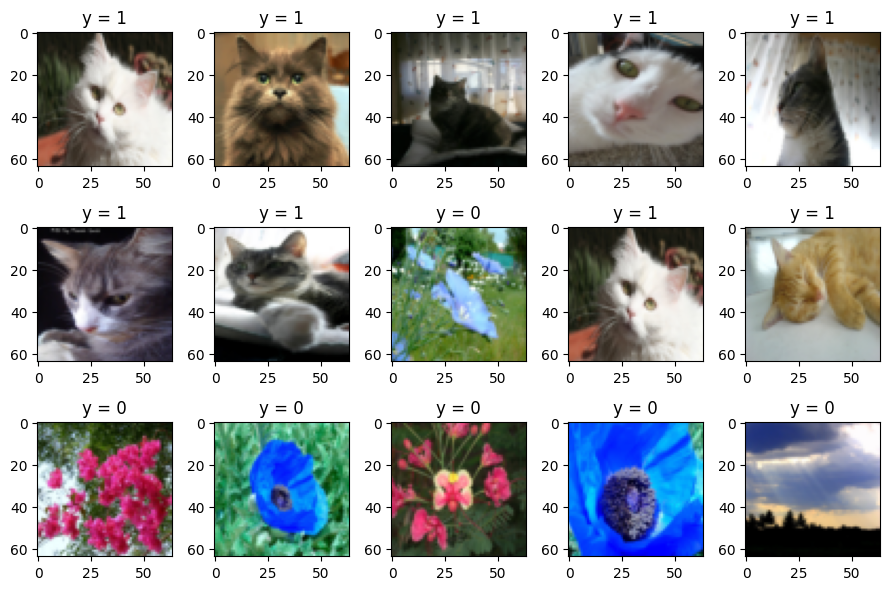

In [27]:
# Let us view some example images
np.random.seed(42)      # for reproducibility purpose
plt.figure(figsize=(9, 6.0))
nrows, ncols = 3, 5
for j in range(nrows * ncols):
    plt.subplot(nrows, ncols, j + 1)
    idx = np.random.randint(low=0, high=x_orig_train.shape[0])
    plt.imshow(x_orig_train[idx])
    plt.title(f"y = {y_train[idx]}")

plt.tight_layout()

In [28]:
# Explore the dataset
m_train, px, py, nc = x_orig_train.shape
print(f"Number of training examples: {m_train}")
print(f"Image size: ({px}, {py})")
print(f"Number of channels: {nc}")

m_test = x_orig_test.shape[0]

Number of training examples: 209
Image size: (64, 64)
Number of channels: 3


In [29]:
# Flatten the data.
m_train, m_test = x_orig_train.shape[0], x_orig_test.shape[0]
X_train_flatten = x_orig_train.reshape(m_train, -1)     
X_test_flatten = x_orig_test.reshape(m_test, -1)

X_train = X_train_flatten / 255.0
X_test = X_test_flatten / 255.0
Y_train = y_train.reshape((-1, 1))
Y_test = y_test.reshape((-1, 1))
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

X_train.shape = (209, 12288)
X_test.shape = (50, 12288)


In [30]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

accuracy_score = log_reg.score(X_test, y_test)
print(f"Accuracy score = {accuracy_score * 100} %")

Accuracy score = 72.0 %


In [31]:
def train_deep_network(X, Y, layer_dims, lr=0.0075, epochs=2500, verbose=False, print_step=20, hist_step=25):

    np.random.seed(seed=1)

    loss_hist = []

    parameters = initialize_parameters_deep(layer_dims=layer_dims)
    for epoch in range(epochs):

        A_last, caches = L_model_forward(X, parameters)
        loss = compute_loss(A_last, Y)

        grads = L_model_backward(A_last, Y, caches)

        parameters = step(parameters, grads, lr)

        if verbose == True:
            print_slide = int(epochs / print_step)
            if epoch % print_slide == 0 or epoch == epochs - 1:
                print(f"Loss after epoch {epoch:<4d}: {loss.squeeze()}")
                
        if epoch % hist_step == 0 or epoch == epochs - 1:
            loss_hist.append(loss.squeeze())

    return parameters, np.array(loss_hist)

In [32]:
n_x = X_train.shape[1]
layer_dims = [12288, 20, 7, 5, 1]
epochs = 2500
lr = 0.0075
parameters, loss_hist = train_deep_network(X_train, Y_train, layer_dims=layer_dims, 
                                           lr=0.0075, epochs=5000, 
                                           verbose=True, print_step=20, hist_step=10)

Loss after epoch 0   : 0.7717493284237688
Loss after epoch 250 : 0.630912009037698
Loss after epoch 500 : 0.5401376634547801
Loss after epoch 750 : 0.43755776879422587
Loss after epoch 1000: 0.3151869888600617
Loss after epoch 1250: 0.23070993174924173
Loss after epoch 1500: 0.1611885466582775
Loss after epoch 1750: 0.13308936870745122
Loss after epoch 2000: 0.1138206066863371
Loss after epoch 2250: 0.10020114734278801
Loss after epoch 2500: 0.08841251177615037
Loss after epoch 2750: 0.08169531620196582
Loss after epoch 3000: 0.07332386975670675
Loss after epoch 3250: 0.06801109235892144
Loss after epoch 3500: 0.06385262635573188
Loss after epoch 3750: 0.06188108855371534
Loss after epoch 4000: 0.05906589592672247
Loss after epoch 4250: 0.05682896037975469
Loss after epoch 4500: 0.055452719620720826
Loss after epoch 4750: 0.054577910991758426
Loss after epoch 4999: 0.054019807164331024


In [33]:
def predict(X, parameters):
    m = X.shape[0]
    probas, _ = L_model_forward(X, parameters)
    Y_pred = np.zeros_like(probas, dtype=np.float64)
    Y_pred[probas >= 0.5] = 1
    Y_pred[probas <  0.5] = 0
    y_pred = Y_pred.ravel()

    return y_pred

In [34]:
y_pred = predict(X_train, parameters)
accuracy_score_train = np.sum(y_pred == y_train) / y_train.shape[0]
print(f"accuracy score (training set): {accuracy_score_train}")

y_pred = predict(X_test, parameters)
accuracy_score_test = np.sum(y_pred == y_test) / y_test.shape[0]
print(f"accuracy score (test set): {accuracy_score_test}")

accuracy score (training set): 0.9904306220095693
accuracy score (test set): 0.78


In [35]:
for j in range(1, len(layer_dims)):
    print(f"parameters['W{j}'].shape = {parameters[f'W{j}'].shape}")
    print(f"parameters['b{j}'].shape = {parameters[f'b{j}'].shape}")
    print(36*"=")

parameters['W1'].shape = (20, 12288)
parameters['b1'].shape = (20,)
parameters['W2'].shape = (7, 20)
parameters['b2'].shape = (7,)
parameters['W3'].shape = (5, 7)
parameters['b3'].shape = (5,)
parameters['W4'].shape = (1, 5)
parameters['b4'].shape = (1,)
